In [9]:
#!rm -r dataset_aumentado/ Castas-Dataset-V1/
#!wget --output-document dataset.zip https://www.dropbox.com/s/lh7sqc1xtjo6duw/dataset_aumentado_todas.zip?dl=0
#!unzip -o -q dataset.zip
#!pip install lime



In [10]:
classes={
    'Codega':'CD',
    'Malvasia Fina':'MF',
    'Malvasia Preta':'MP',
    'Malvasia Rei':'MR',
    'Moscatel Galego':'MG',
    'Moscatel':'MG',
    'Mourisco Tinto':'MT',
    'Rabigato':'RG',
    'Tinta Amarela':'TA',
    'Tinta Barroca':'TB',
    'Tinta Roriz':'TR',
    'Tinto Cao':'TC',
    'Touriga Nacional':'TN'
}

Imports:

In [11]:
import os
import tensorflow.keras as keras
from tensorflow.keras.applications import inception_v3 as inc_net
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tensorflow.keras import backend as K
from sklearn import metrics
import itertools
print('Notebook run using keras:', keras.__version__)
import random

nclasses = 6


Notebook run using keras: 2.5.0


Define diretórios

Monta google drive:

In [12]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [13]:
diretorio = r'C:\Users\Gabriel\OneDrive - Universidade de Tras-os-Montes e Alto Douro\UTAD\2020-2021\Pesquisa\Dataset\videos manual + castasv3 normal - da 5 + DAT simplificado'
train_directory = os.path.join(diretorio, 'train')
val_directory = os.path.join(diretorio, 'validation')
test_directory=os.path.join(diretorio, 'test')

Define modelo:

In [14]:
#definicao do modelo
import tensorflow as tf 
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout, BatchNormalization, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam,RMSprop, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.applications.efficientnet import preprocess_input
target_size_dimension = 300


img_size = (target_size_dimension, target_size_dimension)
diretorio_pesos = r'pesos.h5'

with tf.device('/cpu:0'):
    model = tf.keras.applications.EfficientNetB3(
        include_top=False,
        weights="imagenet",
        pooling='avg',
        input_shape=(target_size_dimension, target_size_dimension, 3)
    )
    #x = Dense(2048, activation='relu')(model.output)
    #x = Dropout(0.25)(x)
    x = Dense(512, activation='relu')(model.output)
    x = Dropout(0.25)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.25)(x)
    output = Dense(nclasses, activation='softmax')(x)
    nmodel = tf.keras.models.Model(model.input, output)

    nmodel.load_weights(diretorio_pesos)

    #nome da ultima camada convolucional
    last_conv_layer_name = 'block14_sepconv2_act'
    nmodel.summary()

Matriz de confusão:

In [15]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def confusion_matrix(test_data_generator, model):
  test_data_generator.reset()
  predictions = model.predict(test_data_generator, steps=test_set.samples)
  # Get most likely class
  predicted_classes = np.argmax(predictions, axis=1)
  true_classes = test_data_generator.classes
  class_labels = list(test_data_generator.class_indices.keys())
  print(class_labels)
  class_labels = [classes[x] for x in class_labels]  

  report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
  cm = metrics.confusion_matrix(true_classes, predicted_classes)
  print(report)
  plot_confusion_matrix(cm, class_labels)

Plotagem da matriz:

Found 521 images belonging to 6 classes.
['Codega', 'Moscatel Galego', 'Rabigato', 'Tinta Roriz', 'Tinto Cao', 'Touriga Nacional']
              precision    recall  f1-score   support

          CD       0.93      0.89      0.91        91
          MG       0.94      0.97      0.96       103
          RG       0.95      0.96      0.95        98
          TR       0.89      0.91      0.90        86
          TC       0.94      0.91      0.93        56
          TN       0.99      0.99      0.99        87

    accuracy                           0.94       521
   macro avg       0.94      0.94      0.94       521
weighted avg       0.94      0.94      0.94       521

Confusion matrix, without normalization
[[ 81   3   0   4   2   1]
 [  0 100   2   1   0   0]
 [  0   1  94   3   0   0]
 [  5   1   2  78   0   0]
 [  1   1   1   2  51   0]
 [  0   0   0   0   1  86]]


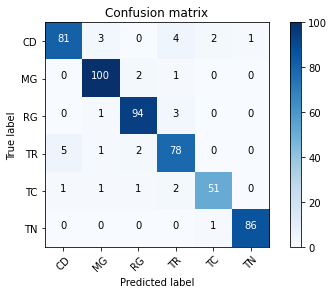

In [16]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)
test_set = test_datagen.flow_from_directory(test_directory, 
                                            target_size=(target_size_dimension, target_size_dimension),
                                            class_mode='categorical',
                                            batch_size=1,
                                            shuffle=False)

test_set.reset()
confusion_matrix(test_set, nmodel)